In [33]:
import pickle
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display, Markdown
from scipy.stats import *

import sklearn as sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.decomposition import PCA
from sklearn.svm import SVC

from sklearn.metrics import roc_auc_score, accuracy_score,precision_score, recall_score, confusion_matrix, f1_score
from sklearn.metrics import classification_report,plot_confusion_matrix

import xgboost
from xgboost import XGBRegressor
from xgboost import XGBClassifier

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

%matplotlib inline

In [2]:
df_raw = pd.read_pickle("./data/df_proper_cleaned.pkl")

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163955 entries, 0 to 167782
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   id                163955 non-null  int64  
 1   userId            163955 non-null  int64  
 2   gender            163955 non-null  object 
 3   sport             163955 non-null  object 
 4   heart_rate_mean   163955 non-null  float64
 5   heart_rate_std    163955 non-null  float64
 6   duration_s        163955 non-null  float64
 7   start_end         163955 non-null  object 
 8   altitude_mean     163955 non-null  float64
 9   altitude_std      163955 non-null  float64
 10  ascend_m          163955 non-null  float64
 11  descend_m         163955 non-null  float64
 12  distance_mean_m   163955 non-null  float64
 13  distance_std_m    163955 non-null  float64
 14  distance_total_m  163955 non-null  float64
 15  speed_mean        163955 non-null  float64
 16  speed_std         16

In [4]:
df_raw.sport.value_counts().index

Index(['bike', 'run', 'mountain bike', 'bike (transport)', 'indoor cycling',
       'walk', 'orienteering', 'cross-country skiing',
       'core stability training', 'fitness walking', 'skate', 'roller skiing',
       'hiking', 'circuit training', 'kayaking', 'rowing', 'weight training',
       'soccer', 'downhill skiing', 'gymnastics'],
      dtype='object')

# Modeling

In [5]:
class Transformer(object):
    def __init__(self, fillnan=True):
        self._NAME_ = 'Transformer'
        
        # categorical features to dummify and then drop
        self.feature_categorical = ['userId', 'gender','sport']
        
        # numeric features to keep
        self.feature_numeric = ['heart_rate_mean', 'heart_rate_std', 
                                   'altitude_mean', 'altitude_std',
                                   'ascend_m', 'descend_m', 'distance_total_m',
                                   'speed_mean','speed_std','duration_s','calories']
        
        # from the top 20 sport list
        self.sports = ['bike', 'run', 'mountain bike', 'bike (transport)', 'indoor cycling',
                       'walk', 'orienteering', 'cross-country skiing',
                       'core stability training', 'fitness walking', 'skate', 'roller skiing',
                       'hiking', 'circuit training', 'kayaking', 'rowing', 'weight training',
                       'soccer', 'downhill skiing', 'gymnastics']
        
        self.gender = ['male','female','unknown']
        
        self.FILLNAN = fillnan
        
    def fit(self, X, y=None):
        if self.FILLNAN:
            col_list = list(set(X.columns) & set(self.feature_numeric))
            self.mean = X[col_list].mean()
        
    def transform(self, X, y=None):
        features = X.columns
        df = pd.DataFrame()
        for feature in features:
            if feature =='start_time':
                date = pd.to_datetime(X[feature])
                #df['year'] = date.dt.year
                df['month'] = date.dt.month
                df['weekday'] = date.dt.weekday
            if feature =='gender':
                for g in self.gender:
                    df[g] = (X[feature]==g).astype(int)
                    
            if feature == 'sport': # dummy transform onto fixed categorical labels
                for s in self.sports:
                    df[s] = (X[feature]==s).astype(int)
            
            if feature in self.feature_numeric:
                df[feature] = X[feature]
        
        if hasattr(self, 'mean') and self.FILLNAN:
            df = df.fillna(self.mean)
            
        # engineering new features
        #if {'calories', 'duration_s'}.issubset(df.columns):
        #    df['calories_rate'] = (1000*df['calories'])/df['duration_s']
        
        return df
        
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)
        
df_transformed = Transformer(fillnan=True).fit_transform(df_raw)
print(df_transformed.info())
df_transformed.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163955 entries, 0 to 167782
Data columns (total 36 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   male                     163955 non-null  int64  
 1   female                   163955 non-null  int64  
 2   unknown                  163955 non-null  int64  
 3   bike                     163955 non-null  int64  
 4   run                      163955 non-null  int64  
 5   mountain bike            163955 non-null  int64  
 6   bike (transport)         163955 non-null  int64  
 7   indoor cycling           163955 non-null  int64  
 8   walk                     163955 non-null  int64  
 9   orienteering             163955 non-null  int64  
 10  cross-country skiing     163955 non-null  int64  
 11  core stability training  163955 non-null  int64  
 12  fitness walking          163955 non-null  int64  
 13  skate                    163955 non-null  int64  
 14  roll

,male,female,unknown,bike,run,mountain bike,bike (transport),indoor cycling,walk,orienteering,...,altitude_mean,altitude_std,ascend_m,descend_m,distance_total_m,speed_mean,speed_std,calories,month,weekday
0,1,0,0,1,0,0,0,0,0,0,...,43.0712,13.475900,407.6,413.0,53049.413644,7.117435,2.182678,1563.0,8,6
1,1,0,0,1,0,0,0,0,0,0,...,35.7248,10.376062,225.4,228.8,32467.566953,7.550103,2.272863,909.0,8,5
2,1,0,0,1,0,0,0,0,0,0,...,62.4256,13.217515,328.8,352.4,45309.570377,7.154326,2.150951,1139.0,8,1
3,1,0,0,1,0,0,0,0,0,0,...,32.6104,11.417463,242.8,238.6,32529.910062,7.416873,2.201268,922.0,8,3
4,1,0,0,0,0,0,1,0,0,0,...,22.7620,8.383674,89.6,107.4,11936.117059,8.721936,2.388718,351.0,8,4


## Data Split: train/test, features/target

In [6]:
# features to be scaled within individual user
'''
feature_scale = ['heart_rate_mean','speed_mean','calories']
userId = df_raw.userId.value_counts().index
for user in userId:
    index = df_raw.userId==user
    temp = df_raw[index]
    for feature in feature_scale:
        mean = np.nanmean(temp[feature])
        std = np.nanstd(temp[feature])
        #print(mean,std)
        df_raw.loc[index, feature] = (temp[feature].values - mean)/std 
'''

"\nfeature_scale = ['heart_rate_mean','speed_mean','calories']\nuserId = df_raw.userId.value_counts().index\nfor user in userId:\n    index = df_raw.userId==user\n    temp = df_raw[index]\n    for feature in feature_scale:\n        mean = np.nanmean(temp[feature])\n        std = np.nanstd(temp[feature])\n        #print(mean,std)\n        df_raw.loc[index, feature] = (temp[feature].values - mean)/std \n"

In [7]:
train_raw, test_raw = train_test_split(df_raw.reset_index(drop=True), test_size=0.1, random_state=42)
print(df_raw.shape, train_raw.shape, test_raw.shape)

(163955, 21) (147559, 21) (16396, 21)


In [8]:
target = 'calories'
features = ['sport', 'gender', 'heart_rate_mean', 'heart_rate_std', 'altitude_mean',
           'altitude_std', 'ascend_m', 'descend_m', 'distance_total_m',
           'speed_mean', 'speed_std', 'duration_s', 'calories', 'start_time']

features.remove(target)

target_limit = np.percentile(df_raw[target],[.01,99.9])

## A linear regression model with Ridge regularization

In [9]:
steps = [('transformer', Transformer()),
         ('poly', PolynomialFeatures()),
         ('rescale',RobustScaler()), 
         #('pca', PCA()),
         ('lr', Ridge())]

model = Pipeline(steps)

param_grid = {'poly__degree': [2], # 2 
              #'pca__n_components': [20], 
              'lr__alpha': [1], #1
              }

search = GridSearchCV(estimator = model, 
                      param_grid = param_grid, 
                      scoring= 'neg_mean_squared_error', 
                      cv = 5, n_jobs = -1, 
                      verbose=1, error_score = 'raise')

search.fit(train_raw[features], train_raw[target])
print(f'Best={search.best_params_}')

y_train_pred_lr = search.predict(train_raw[features])
y_test_pred_lr = search.predict(test_raw[features])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best={'lr__alpha': 1, 'poly__degree': 2}


In [10]:
#from sklearn.inspection import permutation_importance
#r = permutation_importance(search.best_estimator_['lr'], train_raw[features], test_raw[features],
#                            n_repeats=30, random_state=0)

In [11]:
search.best_estimator_['lr'].coef_.shape

(666,)

======== Linear Regression with Ridge ===========
Best={'lr__alpha': 1, 'poly__degree': 2}, Best score = -1.21e+05
mean_absolute_error on Train set =  1.85e+02
mean_absolute_error on  Test set =  1.88e+02
mean_squared_error on Train set =  9.68e+04
mean_squared_error on  Test set =  1.05e+05
r2_score on Train set =  7.52e-01
r2_score on  Test set =  7.38e-01
======== Linear Regression ===========
MAE =  1.85e+02       
MSE =  1.05e+05, 
R2 =  0.738


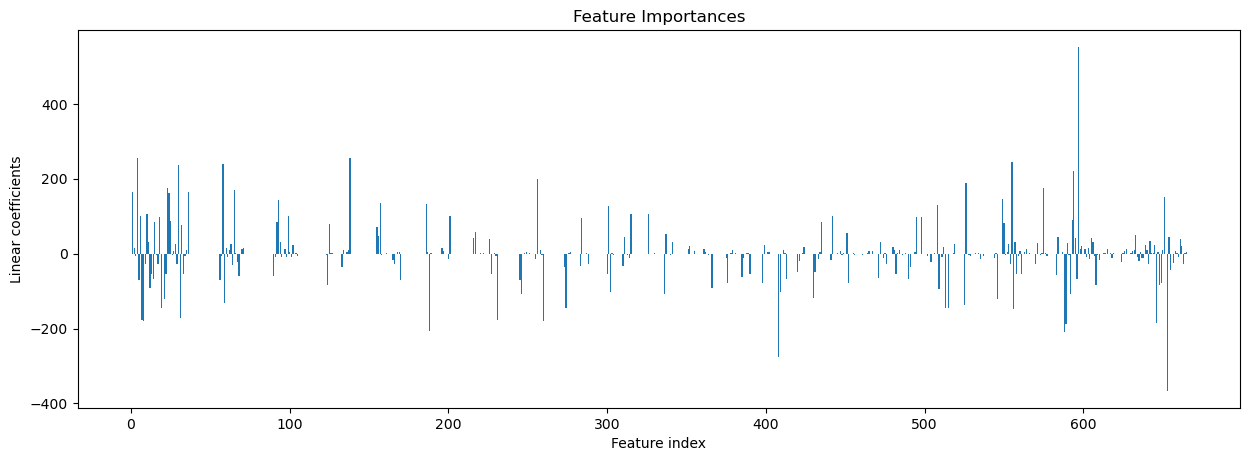

In [12]:
print('======== Linear Regression with Ridge ===========')
print(f'Best={search.best_params_}, Best score = {search.best_score_: .2e}')
all_metrics = [mean_absolute_error, mean_squared_error, r2_score]
for metrics in all_metrics:
    print(f'{metrics.__name__} on Train set = {metrics(train_raw[target], y_train_pred_lr): .2e}')
    print(f'{metrics.__name__} on  Test set = {metrics(test_raw[target], y_test_pred_lr): .2e}')
R2 = r2_score(test_raw[target], y_test_pred_lr)
adjusted_R2 = 1.0 - (1.0 - R2)*(len(test_raw)-1.0)/(len(test_raw)-len(features))
print('======== Linear Regression ===========')
print(f"MAE = {mean_absolute_error(train_raw[target], y_train_pred_lr): .2e} \
      \nMSE = {mean_squared_error(test_raw[target], y_test_pred_lr): .2e}, \nR2 = {R2: .3f}")

plt.figure(figsize=(15,5), dpi =100)
plt.bar(np.arange(len(search.best_estimator_['lr'].coef_)),  search.best_estimator_['lr'].coef_)
plt.title('Feature Importances'), plt.xlabel('Feature index'), plt.ylabel('Linear coefficients');

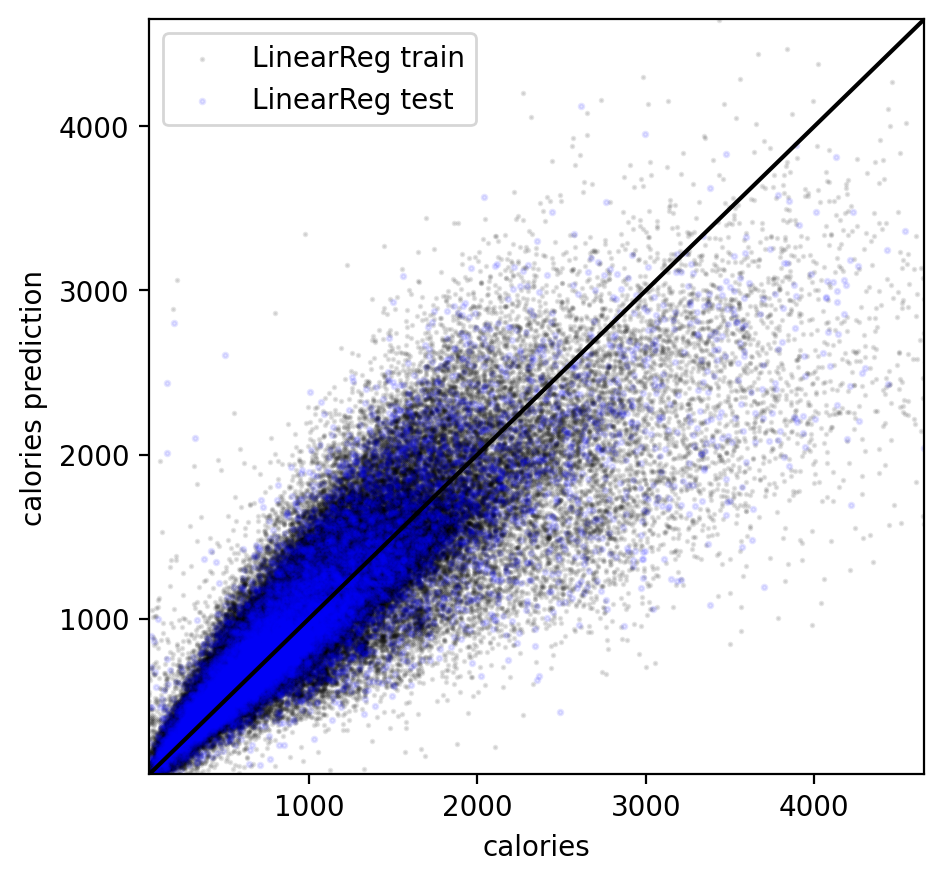

In [13]:
plt.figure(figsize=(5,5),dpi=200)
plt.scatter(train_raw[target], y_train_pred_lr, c = 'k', s = 1, alpha = 0.1, label ='LinearReg train')
plt.scatter(test_raw[target], y_test_pred_lr, c = 'b', s = 3, alpha = 0.1, label ='LinearReg test')

plt.plot(target_limit,target_limit, color = 'k', label = '' )
plt.xlabel(target), plt.ylabel(target + ' prediction'), 
#plt.xscale('log'), plt.yscale('log')
plt.xlim(target_limit)
plt.ylim(target_limit)
plt.legend();

# Xgboost

In [14]:
steps = [('transformer', Transformer()), 
         ('xgbr', XGBRegressor())]

model = Pipeline(steps)
param_grid = {'xgbr__n_estimators': [150], #150
              'xgbr__learning_rate':[0.15], #0.15
              'xgbr__max_depth':[3], # 3
              'xgbr__lambda':[2], 
             }

search = GridSearchCV(estimator = model,
                      param_grid = param_grid, 
                      cv =  5, n_jobs = -1, 
                      scoring = 'neg_mean_squared_error',
                      verbose=1, error_score = 'raise')

search.fit(train_raw[features], train_raw[target])
print(f'Best={search.best_params_}')

y_train_pred_xgbr = search.predict(train_raw[features])
y_test_pred_xgbr = search.predict(test_raw[features])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best={'xgbr__lambda': 2, 'xgbr__learning_rate': 0.15, 'xgbr__max_depth': 3, 'xgbr__n_estimators': 150}


======== XGBR ===========
Best={'xgbr__lambda': 2, 'xgbr__learning_rate': 0.15, 'xgbr__max_depth': 3, 'xgbr__n_estimators': 150}, Best score = -95144.03724738998
mean_absolute_error on Train set =  1.82e+02
mean_absolute_error on  Test set =  1.86e+02
mean_squared_error on Train set =  9.09e+04
mean_squared_error on  Test set =  1.02e+05
r2_score on Train set =  7.67e-01
r2_score on  Test set =  7.46e-01
======== XGBR ===========
MAE =  1.82e+02       
MSE =  1.02e+05, 
R2 =  0.746


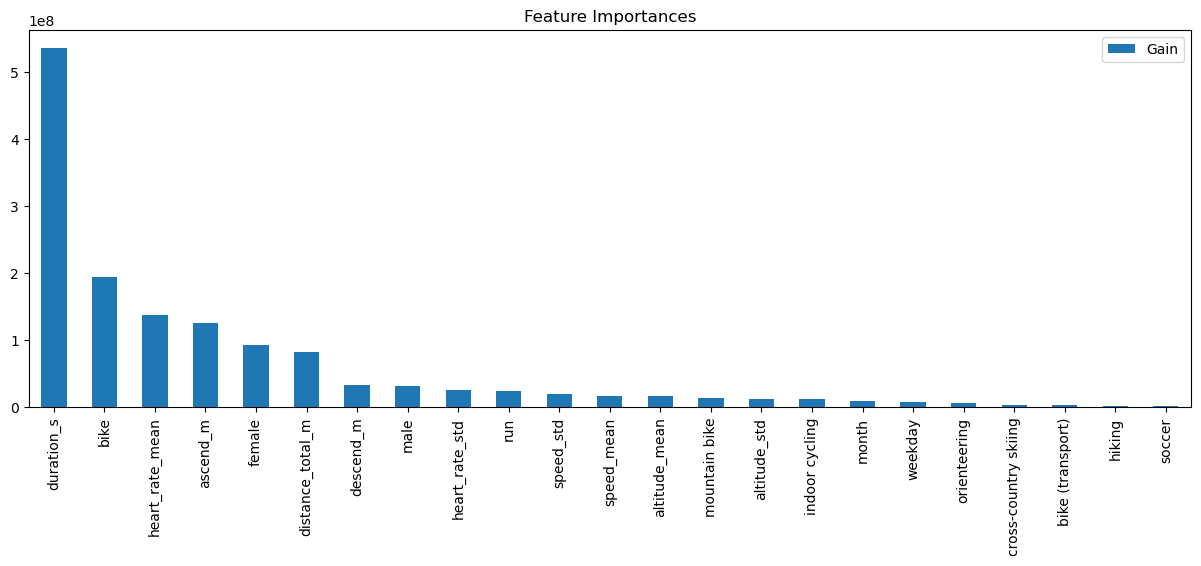

In [15]:
print('======== XGBR ===========')
print(f'Best={search.best_params_}, Best score = {search.best_score_}')

for metrics in all_metrics:
    print(f'{metrics.__name__} on Train set = {metrics(train_raw[target], y_train_pred_xgbr): .2e}')
    print(f'{metrics.__name__} on  Test set = {metrics(test_raw[target], y_test_pred_xgbr): .2e}')
R2 = r2_score(test_raw[target], y_test_pred_xgbr)
adjusted_R2 = 1.0 - (1.0 - R2)*(len(test_raw)-1.0)/(len(test_raw)-len(features))
print('======== XGBR ===========')
print(f"MAE = {mean_absolute_error(train_raw[target], y_train_pred_xgbr): .2e} \
      \nMSE = {mean_squared_error(test_raw[target], y_test_pred_xgbr): .2e}, \nR2 = {R2: .3f}")

feature_importances = pd.DataFrame.from_dict(search.best_estimator_['xgbr'].
                                             get_booster().get_score(importance_type="gain"),
                                             orient='index').rename(columns={0:'Gain'})
fig = plt.figure(figsize=(15,5), dpi=100)
feature_importances.sort_values(by=['Gain'],ascending = False).plot(kind='bar', title='Feature Importances', ax = plt.gca());

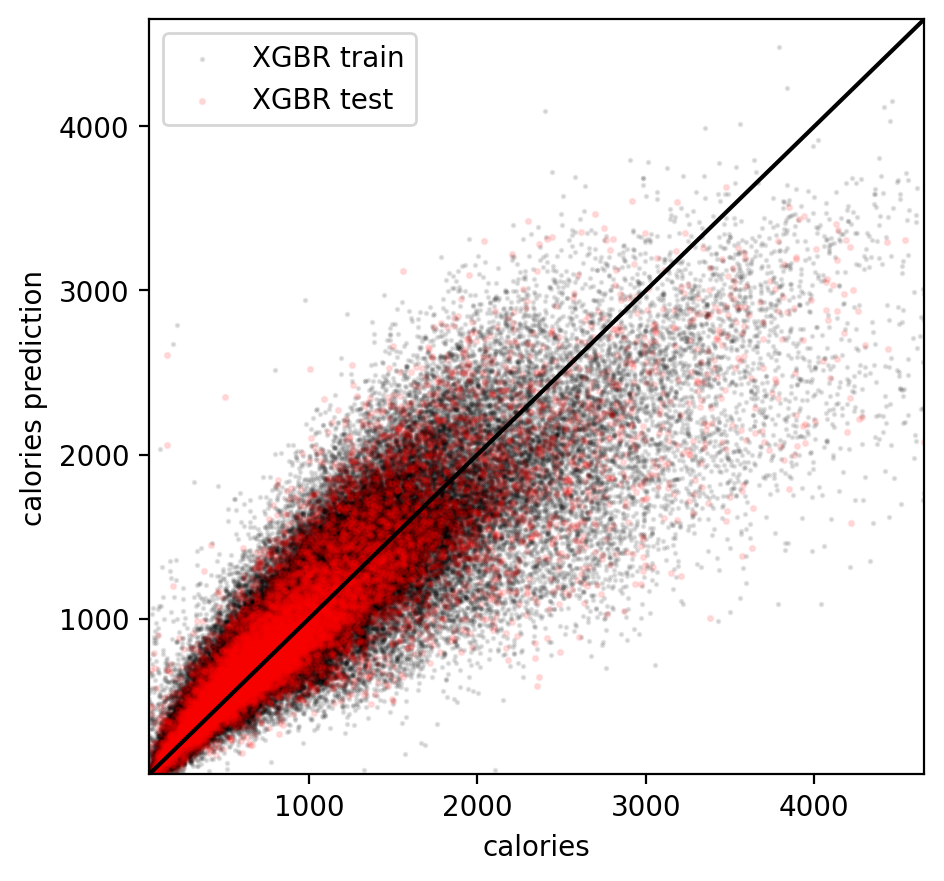

In [16]:
plt.figure(figsize=(5,5),dpi=200)
plt.scatter(train_raw[target], y_train_pred_xgbr, c = 'k', s = 1, alpha = 0.1, label ='XGBR train')
plt.scatter(test_raw[target], y_test_pred_xgbr, c = 'r', s = 3, alpha = 0.1, label ='XGBR test')

plt.plot(target_limit,target_limit, color = 'k', label = '' )
plt.xlabel(target), plt.ylabel(target + ' prediction'), 
#plt.xscale('log'), plt.yscale('log')
plt.xlim(target_limit)
plt.ylim(target_limit)
plt.legend();

# Random Forest

In [17]:
steps = [('transformer', Transformer()), 
         ('rfr', RandomForestRegressor())]

model = Pipeline(steps)
param_grid = {'rfr__n_estimators': [100], #150
              'rfr__max_depth':[10], # 3
              'rfr__min_samples_split':[10], 
             }

search = GridSearchCV(estimator = model,
                      param_grid = param_grid, 
                      cv = 5, n_jobs = -1, 
                      scoring = 'neg_mean_squared_error',
                      verbose=1, error_score = 'raise')
search.fit(train_raw[features], train_raw[target])
print(f'Best={search.best_params_}')

y_train_pred_rfr = search.predict(train_raw[features])
y_test_pred_rfr = search.predict(test_raw[features])

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best={'rfr__max_depth': 10, 'rfr__min_samples_split': 10, 'rfr__n_estimators': 100}


======== Random Forest ===========
Best={'rfr__max_depth': 10, 'rfr__min_samples_split': 10, 'rfr__n_estimators': 100}, Best score = -96432.07384100565
mean_absolute_error on Train set =  1.76e+02
mean_absolute_error on  Test set =  1.89e+02
mean_squared_error on Train set =  8.17e+04
mean_squared_error on  Test set =  1.05e+05
r2_score on Train set =  7.91e-01
r2_score on  Test set =  7.39e-01
======== Random Forest ===========
MAE =  1.76e+02       
MSE =  1.05e+05, 
R2 =  0.739


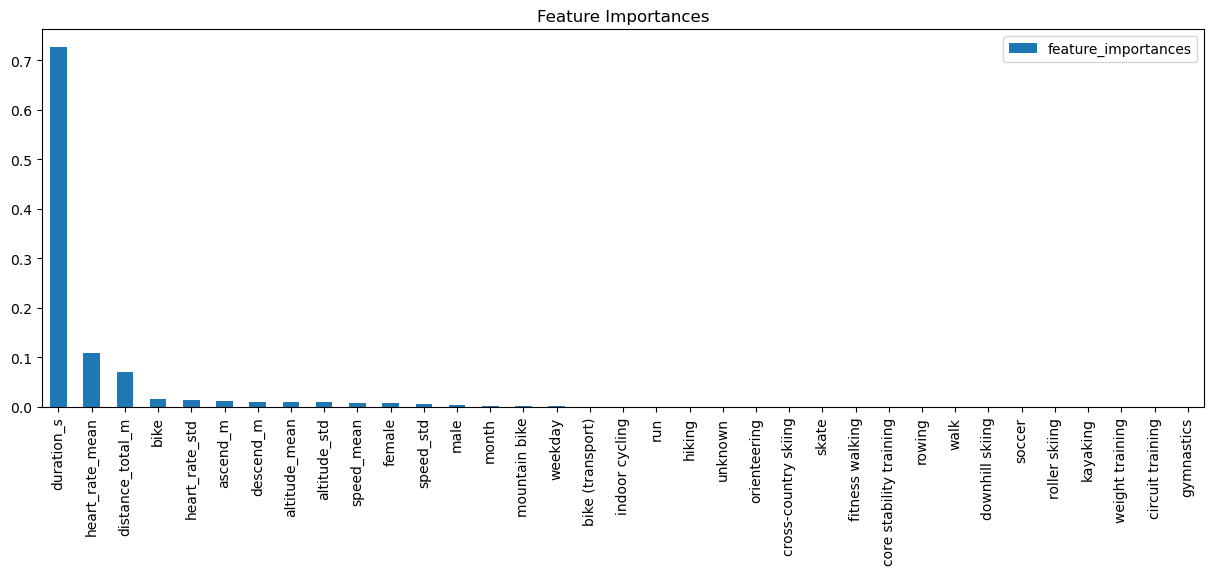

In [18]:
print('======== Random Forest ===========')
print(f'Best={search.best_params_}, Best score = {search.best_score_}')

for metrics in all_metrics:
    print(f'{metrics.__name__} on Train set = {metrics(train_raw[target], y_train_pred_rfr): .2e}')
    print(f'{metrics.__name__} on  Test set = {metrics(test_raw[target], y_test_pred_rfr): .2e}')
R2 = r2_score(test_raw[target], y_test_pred_rfr)
adjusted_R2 = 1.0 - (1.0 - R2)*(len(test_raw)-1.0)/(len(test_raw)-len(features))
print('======== Random Forest ===========')
print(f"MAE = {mean_absolute_error(train_raw[target], y_train_pred_rfr): .2e} \
      \nMSE = {mean_squared_error(test_raw[target], y_test_pred_rfr): .2e}, \nR2 = {R2: .3f}")

feature_importances = pd.DataFrame(data=search.best_estimator_['rfr'].feature_importances_,
                                  index=search.best_estimator_['rfr'].feature_names_in_,
                                  columns=['feature_importances'])

fig = plt.figure(figsize=(15,5), dpi=100)
feature_importances.sort_values(by=['feature_importances'], ascending=False).plot(kind='bar', title='Feature Importances', ax = plt.gca());

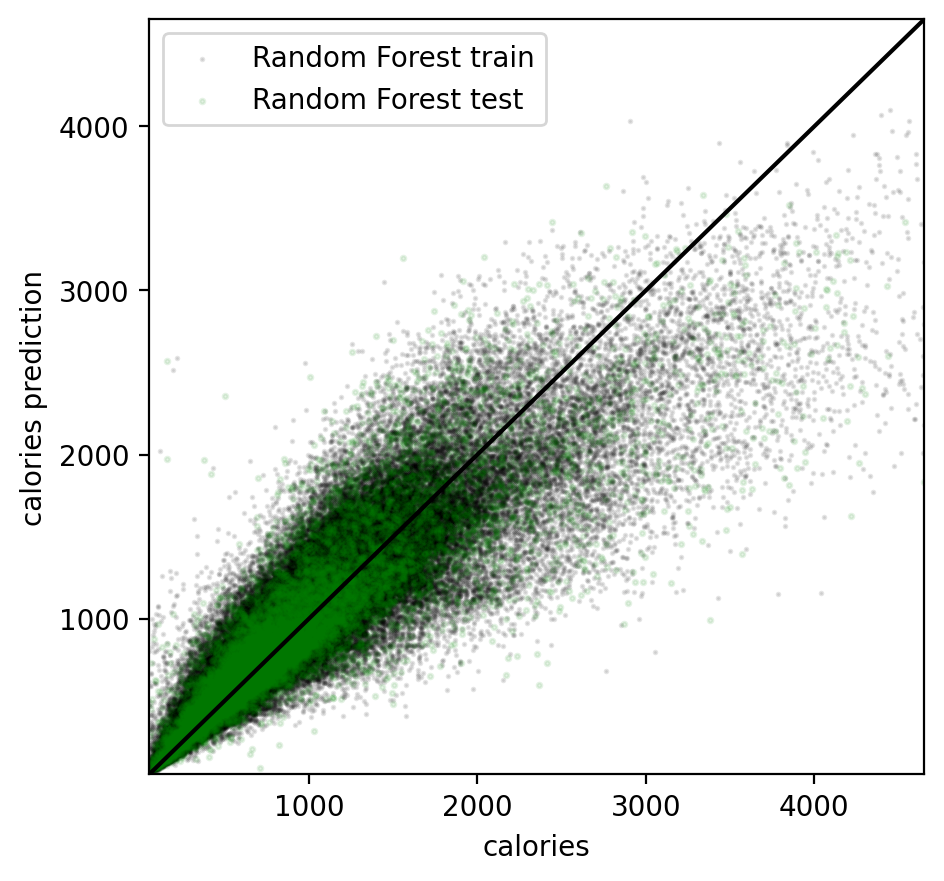

In [19]:
plt.figure(figsize=(5,5),dpi=200)
plt.plot(target_limit, target_limit, color = 'k', label = '' )
plt.scatter(train_raw[target], y_train_pred_rfr, c = 'k', s = 1, alpha = 0.1, label ='Random Forest train')
plt.scatter(test_raw[target], y_test_pred_rfr, c = 'g', s = 3, alpha = 0.1, label ='Random Forest test')
plt.xlabel(target), plt.ylabel(target + ' prediction'), 
#plt.xscale('log'), plt.yscale('log')
plt.xlim(target_limit), plt.ylim(target_limit)
plt.legend();

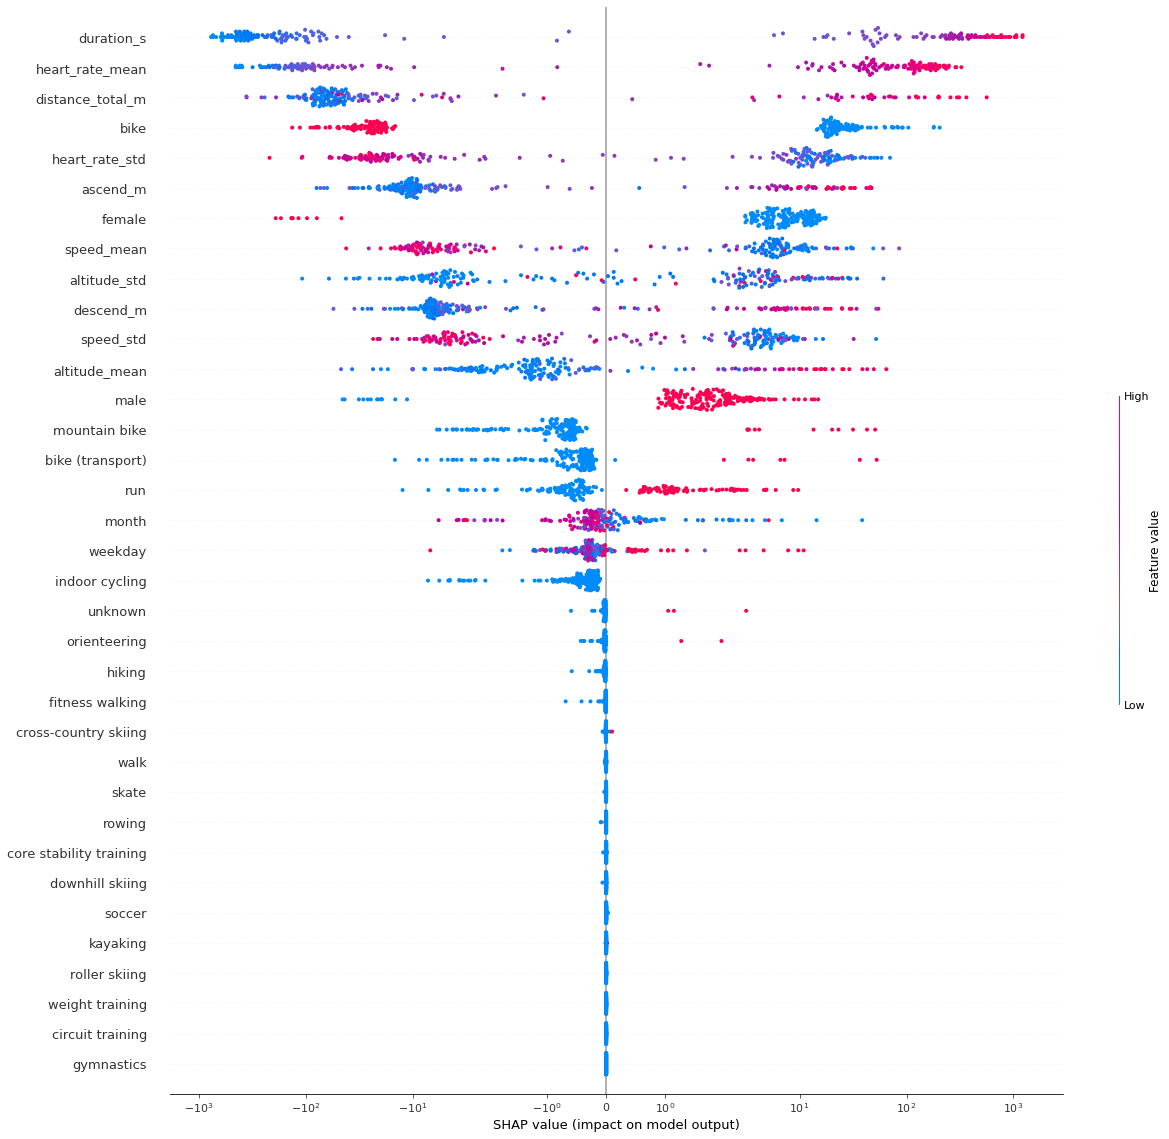

In [20]:
import shap
shap.initjs()
shap_model = search.best_estimator_['rfr']
X_test = Transformer().fit_transform(test_raw[features][:200])

shap_values = shap.TreeExplainer(shap_model).shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_size = (20,20), max_display=len(X_test), use_log_scale = True,)

# Multiclass Classification
* To predict a sport type based on other features

## Classify with simple logistic regression

In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression

class label_encoder(object):
    def __init__(self, df=None):
        # unique label, counts in descending order
        self.sports = list(df.sport.value_counts(ascending=False).index) 
        self.dmap = {sport:i for i,sport in enumerate(self.sports)}
        self.dmap_inverse = {i:sport for i,sport in enumerate(self.sports)}
        
    def encoder(self, labels):
        return list(map(lambda x:self.dmap[x], labels))

    def decoder(self, codes):
        return list(map(lambda x:self.dmap_inverse[x], codes)) 

code = label_encoder(df_raw).encoder(['bike','run'])
decode = label_encoder(df_raw).decoder(code)
code, decode

([0, 1], ['bike', 'run'])

In [22]:
target = 'sport'
features = ['sport', 'gender', 'heart_rate_mean', 'heart_rate_std', 'altitude_mean',
           'altitude_std', 'ascend_m', 'descend_m', 'distance_total_m',
           'speed_mean', 'speed_std', 'duration_s', 'calories', 'start_time']

features.remove(target)

In [23]:
# split train test, remember to stratify according to the categorical variables
train_raw, test_raw = train_test_split(df_raw, test_size=0.1, random_state=42, stratify = df_raw[target] ) #['sport','gender']
print(df_raw.shape, train_raw.shape, test_raw.shape)

(163955, 21) (147559, 21) (16396, 21)


In [24]:
LE = label_encoder(df_raw)
y_train =  LE.encoder(train_raw[target])
y_test = LE.encoder(test_raw[target])

In [34]:
steps = [('transformer', Transformer()), 
         ('rescale',RobustScaler()),
         ('lor', LogisticRegression(penalty='l2', multi_class = 'ovr', solver='sag', class_weight='balanced',max_iter=20))] #

model = Pipeline(steps)
param_grid = {'lor__C': [10], #1
             }

search = GridSearchCV(estimator = model,
                      param_grid = param_grid,
                      cv = 5, n_jobs = -1, 
                      scoring = 'roc_auc_ovr', verbose=1)

search.fit(train_raw[features], y_train)
print(f'Best={search.best_params_}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:352: ConvergenceWarning: The max_iter 

Best={'lor__C': 10}


In [35]:
y_train_pred_lor = search.predict(train_raw[features])
y_test_pred_lor = search.predict(test_raw[features])
y_train_pred_proba_lor = search.predict_proba(train_raw[features])
y_test_pred_proba_lor = search.predict_proba(test_raw[features])

print('======== Logistic Regression ==========')
ruc_train = roc_auc_score(y_train, y_train_pred_proba_lor, average='weighted', multi_class='ovr')
ruc_test = roc_auc_score(y_test, y_test_pred_proba_lor, average='weighted', multi_class='ovr')
print(f'AUC ROC averaged on Train ={ruc_train: .3f}')
print(f'AUC ROC averaged on  Test ={ruc_test: .3f}')

print('=====================Logistic Regression Train =====================')
print(classification_report(y_train,y_train_pred_lor))
print('=====================Logistic Regression  Test =====================')
print(classification_report(y_test,y_test_pred_lor))

======== Logistic Regression ==========
AUC ROC averaged on Train = 0.933
AUC ROC averaged on  Test = 0.931
=====================Logistic Regression Train =====================
              precision    recall  f1-score   support

           0       0.89      0.75      0.81     62893
           1       0.94      0.88      0.91     62823
           2       0.45      0.36      0.40      9608
           3       0.26      0.36      0.30      6874
           4       0.03      0.01      0.01      1124
           5       0.33      0.49      0.39      1113
           6       0.04      0.03      0.03       780
           7       0.11      0.44      0.17       707
           8       0.01      0.02      0.01       365
           9       0.09      0.42      0.15       262
          10       0.01      0.18      0.02       231
          11       0.03      0.51      0.06       214
          12       0.15      0.46      0.23       212
          13       0.02      0.05      0.02        73
          14

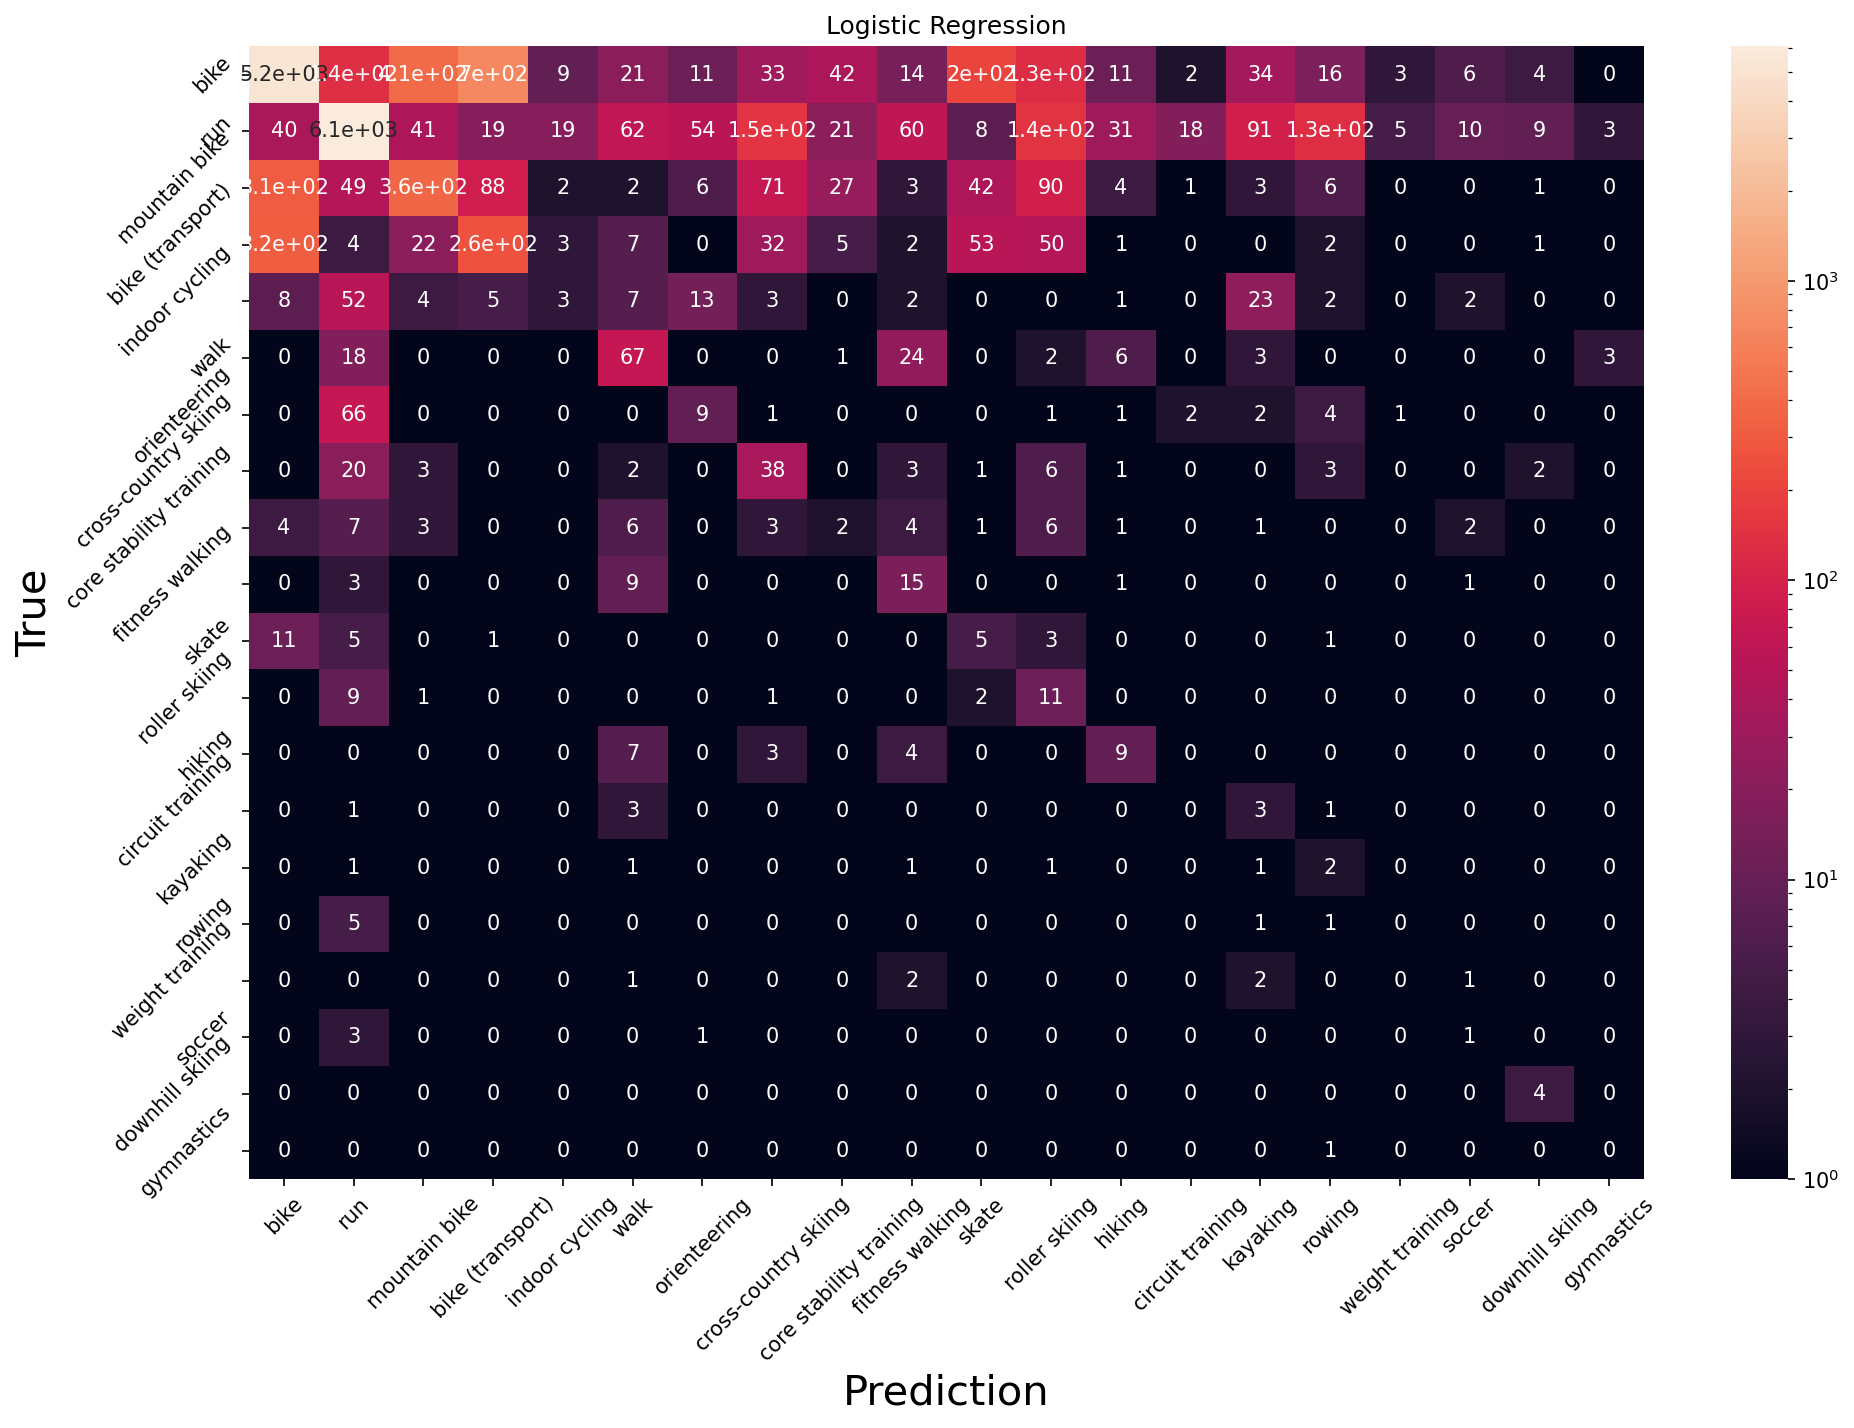

In [36]:
from matplotlib.colors import LogNorm, Normalize
cm = confusion_matrix(y_test, y_test_pred_lor)
fig, ax = plt.subplots(figsize=(15,10),dpi=150) 
sns.heatmap(cm, annot=True, norm=LogNorm(vmin=1.0, clip=True), ax=ax); # heatmap in log scale
ax.set_xticklabels(LE.sports, rotation=45)
ax.set_yticklabels(LE.sports, rotation=45)
plt.title('Logistic Regression')
plt.xlabel('Prediction', fontsize=20), plt.ylabel('True', fontsize=20);

## Classify with SVM

In [28]:
steps = [('transformer', Transformer()), 
         ('rescale',RobustScaler()),
         ('svc', SVC(kernel='rbf', decision_function_shape='ovr', probability=True, max_iter=20))] #=

model = Pipeline(steps)
param_grid = {'svc__C': [1], #1
             }

search = GridSearchCV(estimator = model,
                      param_grid = param_grid,
                      cv = 5, n_jobs = -1, 
                      scoring = 'roc_auc_ovr', verbose=1)

search.fit(train_raw[features], y_train)
print(f'Best={search.best_params_}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=20).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=20).  Con

Best={'svc__C': 1}


In [29]:
y_train_pred_svc = search.predict(train_raw[features])
y_test_pred_svc = search.predict(test_raw[features])
#y_train_pred_proba_svc = search.predict_proba(train_raw[features])
y_test_pred_proba_svc = search.predict_proba(test_raw[features])

print('======== SVM ==========')
#ruc_train = roc_auc_score(y_train, y_train_pred_proba_svc, average='weighted', multi_class='ovr')
ruc_test = roc_auc_score(y_test, y_test_pred_proba_svc, average='weighted', multi_class='ovr')
#print(f'AUC ROC averaged on Train ={ruc_train: .3f}')
print(f'AUC ROC averaged on  Test ={ruc_test: .3f}')

print('=====================SVM Train =====================')
print(classification_report(y_train,y_train_pred_svc))
print('=====================SVM  Test =====================')
print(classification_report(y_test,y_test_pred_svc))

======== SVM ==========
AUC ROC averaged on  Test = 0.627
=====================SVM Train =====================
              precision    recall  f1-score   support

           0       0.59      0.24      0.34     62893
           1       0.54      0.07      0.13     62823
           2       0.10      0.16      0.13      9608
           3       0.12      0.05      0.08      6874
           4       0.71      0.00      0.01      1124
           5       0.04      0.01      0.01      1113
           6       0.02      0.26      0.03       780
           7       0.02      0.02      0.02       707
           8       0.00      0.00      0.00       365
           9       0.02      0.13      0.03       262
          10       0.01      0.13      0.01       231
          11       0.00      0.53      0.00       214
          12       0.03      0.30      0.05       212
          13       0.00      0.10      0.00        73
          14       0.00      0.10      0.00        69
          15       0.01 

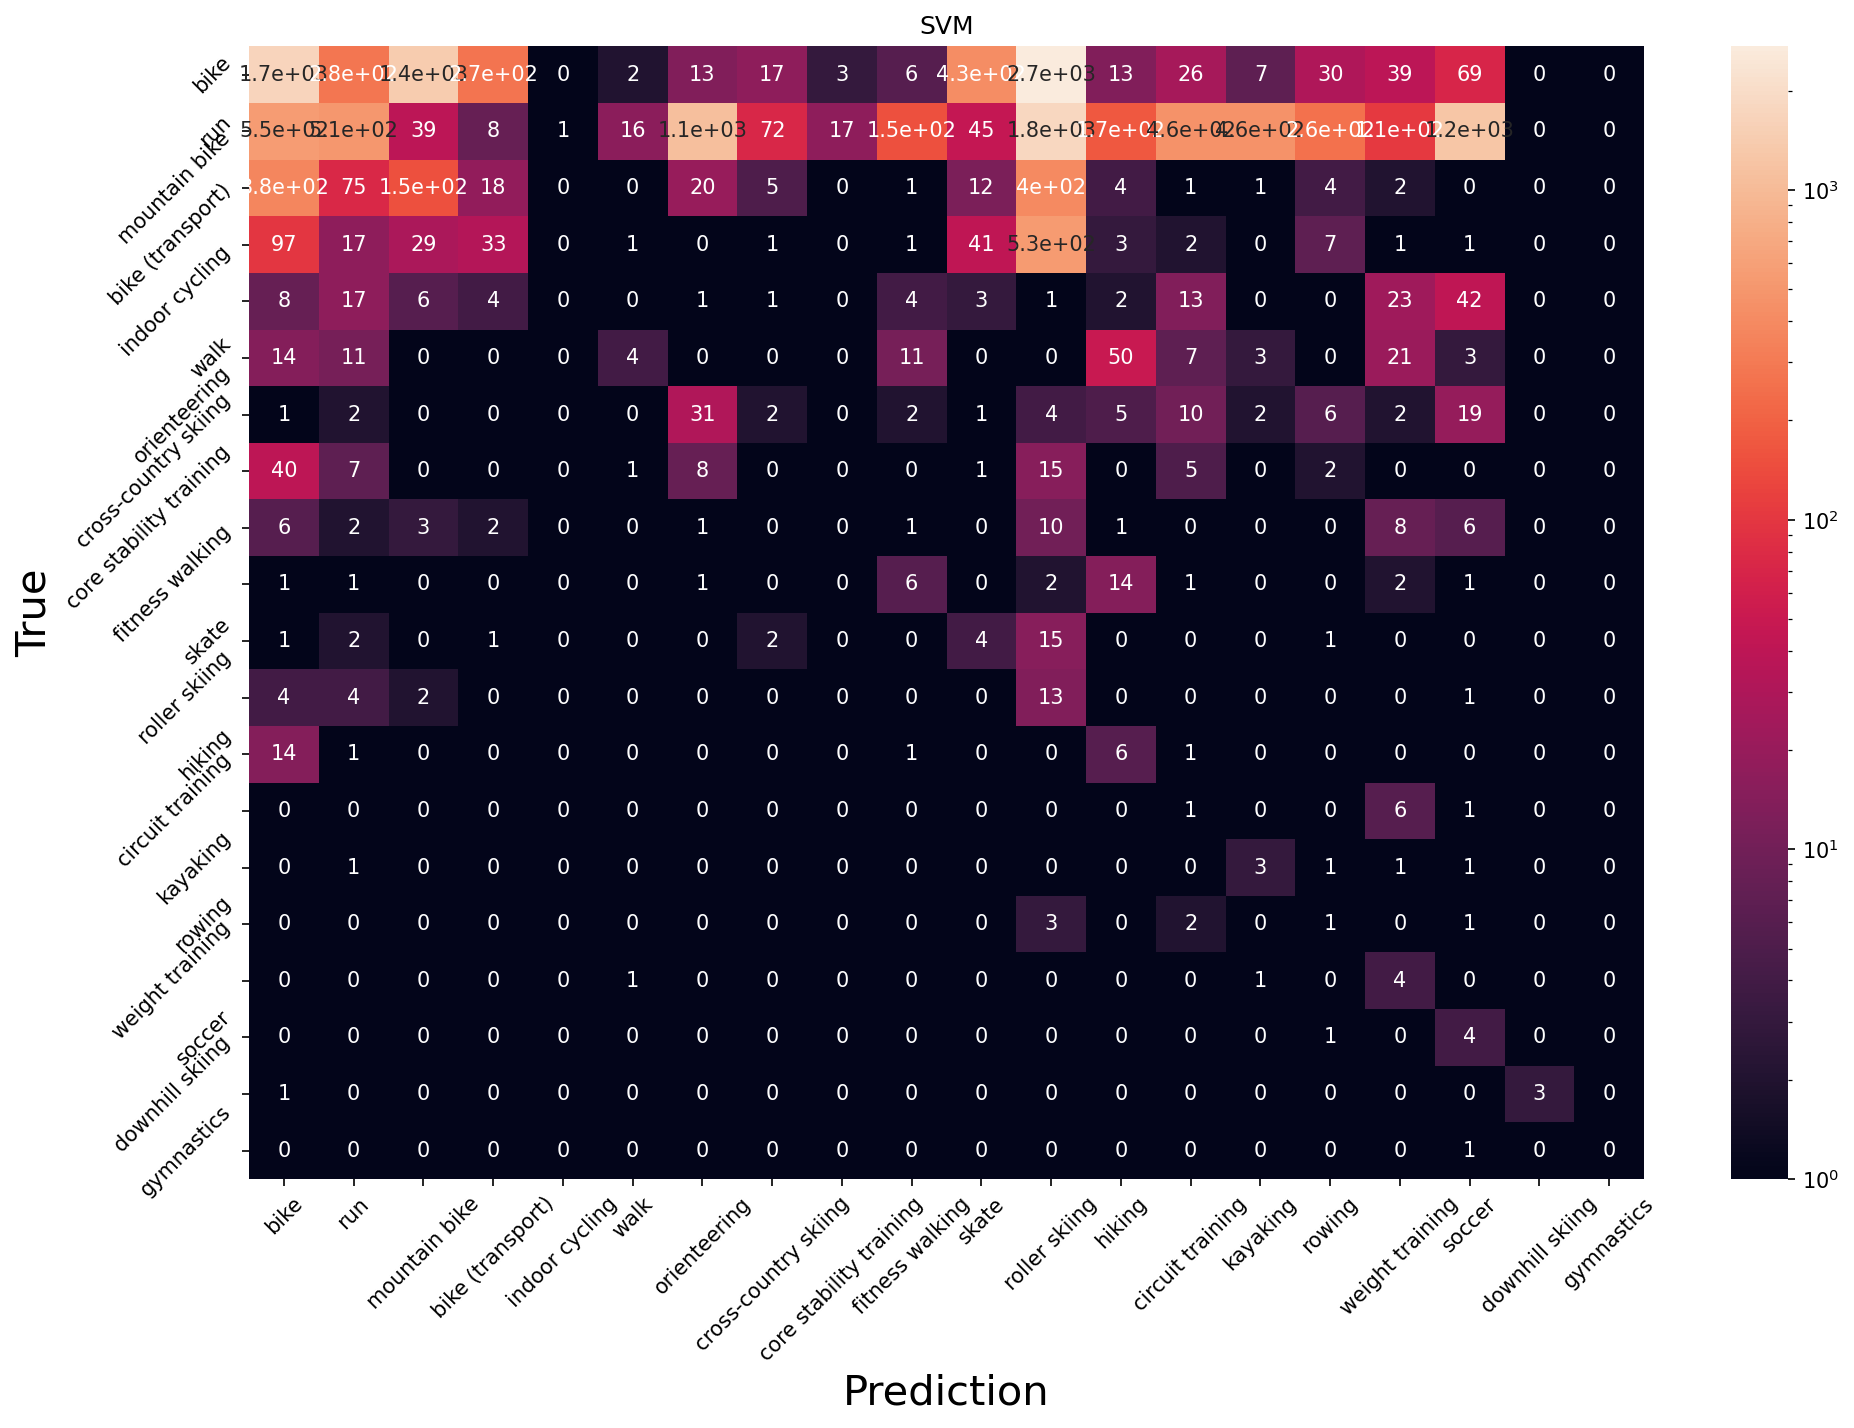

In [30]:
cm_svc = confusion_matrix(y_test, y_test_pred_svc)
fig, ax = plt.subplots(figsize=(15,10),dpi=150) 
sns.heatmap(cm_svc, annot=True, norm=LogNorm(vmin=1.0, clip=True), ax=ax); # heatmap in log scale
ax.set_xticklabels(LE.sports, rotation=45)
ax.set_yticklabels(LE.sports, rotation=45)
plt.title('SVM')
plt.xlabel('Prediction', fontsize=20), plt.ylabel('True', fontsize=20);

# XGBoost Classifier

In [37]:
steps = [('transformer', Transformer()), 
         ('xgbc', XGBClassifier())]

model = Pipeline(steps)
param_grid = {'xgbc__n_estimators': [150], #150
              'xgbc__learning_rate':[0.15], #0.15
              'xgbc__max_depth':[3], # 3
              'xgbc__gamma':[0.5], 
             }

search = GridSearchCV(estimator = model,
                      param_grid = param_grid, 
                      cv =  5, n_jobs = -1, 
                      scoring = 'roc_auc_ovr', verbose=1)

search.fit(train_raw[features], y_train)
print(f'Best={search.best_params_}')

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of 

[20:10:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:10:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:10:47] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:10:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[20:10:48] WARNING: /Users/runner/miniforge3/c

In [ ]:
y_train_pred_xgbc = search.predict(train_raw[features])
y_test_pred_xgbc = search.predict(test_raw[features])

y_train_pred_proba_xgbc = search.predict_proba(train_raw[features])
y_test_pred_proba_xgbc = search.predict_proba(test_raw[features])

print('======== XGBClassifier ==========')
ruc_train = roc_auc_score(y_train, y_train_pred_proba_xgbc, average='weighted', multi_class='ovr')
ruc_test = roc_auc_score(y_test, y_test_pred_proba_xgbc, average='weighted', multi_class='ovr')
print(f'AUC ROC averaged on Train ={ruc_train: .3f}')
print(f'AUC ROC averaged on  Test ={ruc_test: .3f}')

print('=====================XGBClassifier Train =====================')
print(classification_report(y_train,y_train_pred_svc))
print('=====================XGBClassifier  Test =====================')
print(classification_report(y_test,y_test_pred_svc))

In [ ]:
cm_xgbc = confusion_matrix(y_test, y_test_pred_xgbc)
fig, ax = plt.subplots(figsize=(15,10),dpi=150) 
sns.heatmap(cm_xgbc, annot=True, norm=LogNorm(vmin=1.0, clip=True), ax=ax); # heatmap in log scale
ax.set_xticklabels(LE.sports, rotation=45)
ax.set_yticklabels(LE.sports, rotation=45)
plt.title('XGBClassifier')
plt.xlabel('Prediction', fontsize=20), plt.ylabel('True', fontsize=20);

In [ ]:
import shap
import matplotlib.pyplot as plt
shap.initjs()
shap_model = search.best_estimator_['xgbc']
X_test = Transformer().fit_transform(test_raw[features][:200])

shap_values = shap.TreeExplainer(shap_model).shap_values(X_test)
shap.summary_plot(shap_values, X_test, plot_size = (20,20), 
                  max_display=len(X_test),class_inds='original',
                  color =plt.get_cmap("tab20c"),class_names= LE.sports)

In [ ]:
fig, ax = plt.subplots(figsize=(15,10),dpi=150) 
xgboost.plot_importance(search.best_estimator_['xgbc'], importance_type="gain", ax=ax)
plt.title("XGBClassifier feature importances");